In [ ]:
# !pip install numpy==1.21
#!pip install pyyaml

In [1]:
from pydsge import * # imports eg. the DSGE class and the examples
from grgrlib import pplot
import pandas as pd
import matplotlib.pyplot as plt 

The code below is application of an amazing Python package, <a href="https://pydsge.readthedocs.io/en/latest/getting_started.html" target="_blank">Pydsge</a> - a package for solving, filtering and estimating DSGE models. The package's documentation shows the application for counterfactual analysis and historical docompositions; below I create an example of how to use the package for forecasting.

Model used is a small New-Keynsean model with finantions from the paper *"Monetary policy and speculative stock markets"* (Boehl, 2017). 

# Load model

In [2]:
# Yaml file contains the model setup, similar to Matlab/Dynare .mod files
yaml_file, data_file = 'dfi.yaml', 'tsdata.csv'

In [3]:
# Load the model and calibrated parameters
mod = DSGE.read(yaml_file)
par = mod.set_par('calib')


In [4]:
shock_list = ('e_r', 1.0, 0) # (name, size, period) e_r is the monetary policy shock
X1, (L1, K1), _ = mod.irfs(shock_list, verbose=True)

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

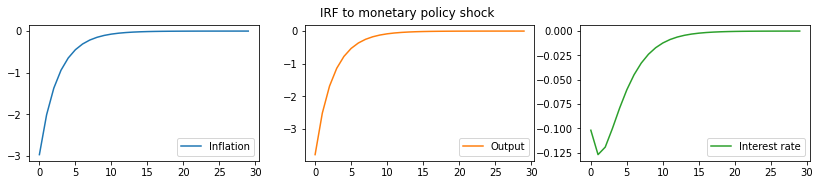

In [5]:
(X1.loc[:,['Pi', 'y', 'r']]
 .rename(columns = {'Pi':'Inflation', 'y':'Output', 'r':'Interest rate'})
 .plot(subplots = True, figsize = (14,2.5), layout = (1, 3), title = 'IRF to monetary policy shock' ) 
)

# Filtering

In [6]:
df = pd.read_csv(data_file, parse_dates=['date'], index_col=['date'])
df.index.freq = 'Q' # let pandas know that this is quartely data

# Truncate the FFR at model-specifed ELB
df['FFR'] = np.maximum(df['FFR'],mod.get_par('elb_level'))

# Add the data to the model
mod.load_data(df)


,GDP,Infl,FFR
date,,,
1995-03-31,0.16884,0.60269,1.45
1995-06-30,0.13066,0.44765,1.51
1995-09-30,0.64258,0.42713,1.45
1995-12-31,0.45008,0.47539,1.43
1996-03-31,0.47113,0.50984,1.34
...,...,...,...
2017-03-31,0.41475,0.49969,0.18
2017-06-30,0.54594,0.25245,0.24
2017-09-30,0.54391,0.51972,0.29


In [7]:
# use a Bayesian Filter to smooth out the hidden states of the model - see package example for details

mod.set_par('calib') # Reset the parameters to yaml specification
mod.create_filter(N=500, ftype='TEnKF', seed=0)
mod.filter.R = mod.create_obs_cov(1e-1)

# set measurment error of the FFR to very small value, as it is observable
ffr_idx = mod.observables.index('FFR')
mod.filter.R[ffr_idx,ffr_idx] = 1e-4

# Run filter
FX = mod.run_filter(verbose=True, smoother=True)

[run_filter:]   Filtering done in 1.768s.


Plot (selected) filtered variables

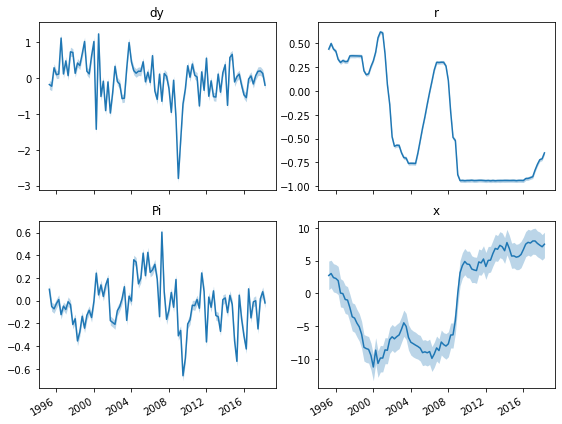

In [8]:
plot_vars = ('dy','r','Pi', 'x')
fig, ax, _ = pplot(FX[:,:, mod.vix(plot_vars)], mod.data.index, labels=plot_vars)


# Forecasting

Extract smoothed shocks

In [9]:

nsamples = 20
epd = mod.extract(nsamples = nsamples)

100%|██████████| 20/20 [01:15<00:00,  3.76s/ sample(s)]


mod.extract returns a dictionary (epd). It contains the parameters of each sample (here, they are all the same), the smoothed means and covariances, the implied series of observables, and the series of smoothed shock residuals. The flags entry contains potential error messages from smoothing.

Below I extend the returned series of shocks, so that filter continues iterating forward after the last observation. In the first scenario (fcst0), I assume no future shocks, while in the second scenario (fcst1) I enter the monetary policy shock at T1.

In [10]:
fcast_periods = 80
fcast_start = mod.data.index[-1]

# Extend the series of historical shocks so that filter also runs out of sample
shocks_ahead = np.array([np.concatenate((epd['resid'][i], np.tile(np.repeat(0, epd['resid'][i].shape[1]), (fcast_periods,1))))
 for i in range(nsamples)])


# Create mask so that we assume no shocks in the future
msk0 = mod.mask.reindex(pd.date_range(mod.data.index[0],periods = shocks_ahead.shape[1], freq = 'q'))
msk0.loc[msk0.index > mod.data.index[-1]] = 0

# # Baseline forecast
fcst0 =  mod.simulate(dict(pars = epd["pars"],
                             init = epd['init'],
                             resid = shocks_ahead),
                      mask = msk0)[0]


# # Forecast with shock applied (Monetary policy shock at T1)
msk0.loc['2018-06-30', 'e_r'] = 1

fcst1 =  mod.simulate(dict(pars = epd["pars"],
                             init = epd['init'],
                             resid = shocks_ahead, flags = epd['flags']),
                    mask = msk0)[0]




### Plot forecast scenarios

**Using default plotting function from Pydsge package**

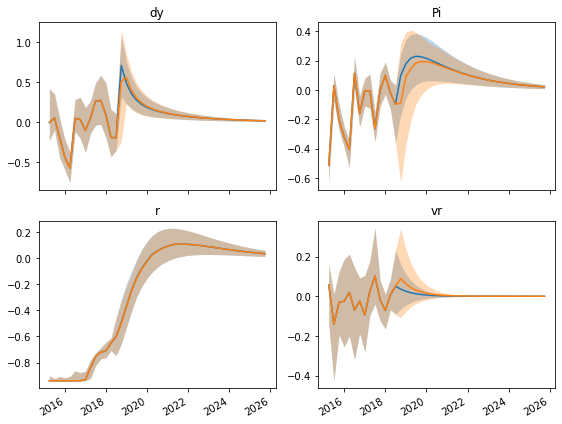

In [12]:
plot_start, plot_end = '2015-03-31', '2025-12-31'
plot_vars = ('dy', 'Pi', 'r', 'vr')
v = mod.vix(plot_vars)

idx_start, idx_end = msk0.index.get_loc(plot_start), msk0.index.get_loc(plot_end)
fig, ax, _ = pplot((fcst0[:,idx_start:idx_end,v], fcst1[:,idx_start:idx_end,v]), msk0.index[idx_start:idx_end], labels=mod.vv[v])


**Using matplotlib**

In [13]:
# Create  multiindex df for easy manipulation
fcst0_df = dict(
median = pd.DataFrame(np.nanmedian(fcst0, axis = 0)[:-1,:], index = msk0.index, columns = mod.vv),
min = pd.DataFrame(np.nanmin(fcst0, axis = 0)[:-1,:], index = msk0.index, columns = mod.vv),
max = pd.DataFrame(np.nanmax(fcst0, axis = 0)[:-1,:], index = msk0.index, columns = mod.vv)
)

fcst0_df = pd.concat(fcst0_df).unstack(0)

<AxesSubplot:xlabel='date'>

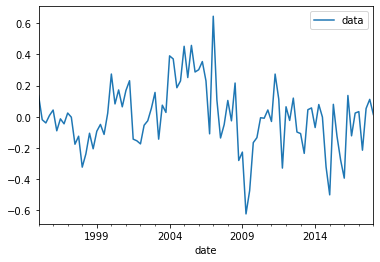

In [14]:
#fcst0_df['Pi']['median'][:'2018-3-31'].plot(legend = True)
(df['Infl']-df['Infl'].mean()).rename('data').plot(legend = True)

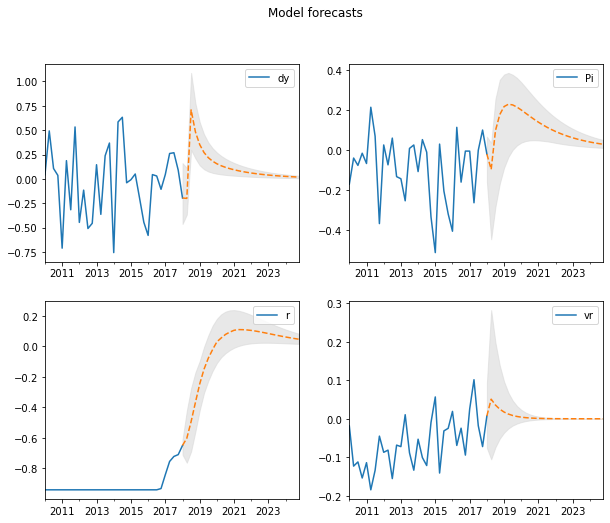

In [15]:
plot_start, plot_end = '2010','2024'
plot_vars = ('dy', 'Pi', 'r', 'vr')
nrow, ncol = int(np.ceil(len(plot_vars)/2)), 2
fig, axs = plt.subplots(nrow, ncol, figsize = (ncol*5, nrow*4))
fig.suptitle('Model forecasts')
for ax, var in zip(axs.flat, plot_vars):

    fcst0_df[var]['median'][plot_start:fcast_start].rename(var).plot(ax = ax, legend = True)
    fcst0_df[var]['median'][fcast_start:plot_end].plot(ax=ax, ls = '--')
    
    ax.fill_between(fcst0_df[var]['median'][fcast_start:plot_end].index,
                    fcst0_df[var]['min'][fcast_start:plot_end],
                    fcst0_df[var]['max'][fcast_start:plot_end],
                    alpha = 0.5, color = 'lightgray')